In [387]:
# Importing the libraries and removing the warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings("ignore")

In [388]:
df = pd.read_csv('day.csv')
df.shape

(730, 16)

In [389]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [390]:
sns.set(rc={'figure.figsize' : (15,8)})
sns.set_theme(palette=sns.color_palette("husl"))
# creating the font dictionaries to set the style for the x and y labels for our plots
fontdict = {'fontsize': 15, 'fontweight' : 5, 'color' : 'Brown'}

Let's analyse the relationship between numerical variables and the dependent variable by plotting pairplot

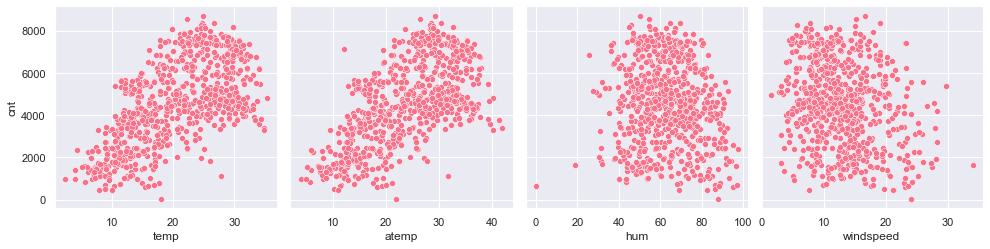

In [391]:
sns.pairplot(data=df,x_vars=['temp','atemp','hum','windspeed'],y_vars='cnt', height = 3.5)
plt.show()

Clearly, total bikes rented count looks highly correlated with actual and felt temperature, but not so much with humidity and windspeed

Let's analyse the distribution of these numerical variables individually just to get the idea of their spread

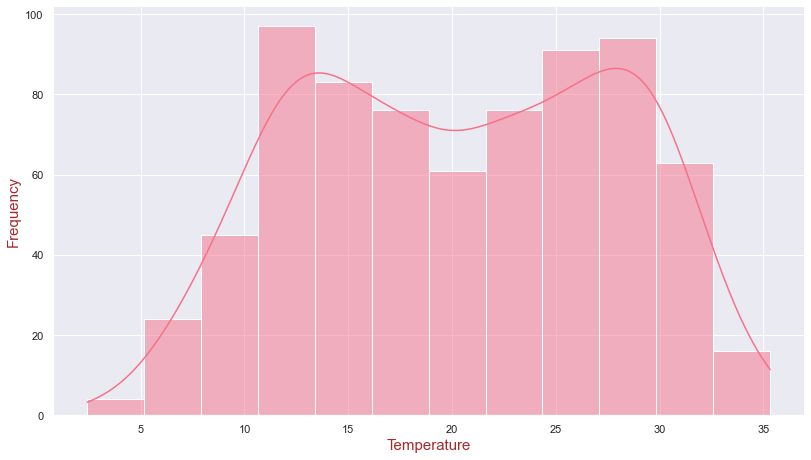

In [392]:
sns.displot(data=df,x="temp",kde=True,height=6.5,aspect=1.75)
plt.xlabel('Temperature',fontdict=fontdict)
plt.ylabel('Frequency',fontdict=fontdict)
plt.show()

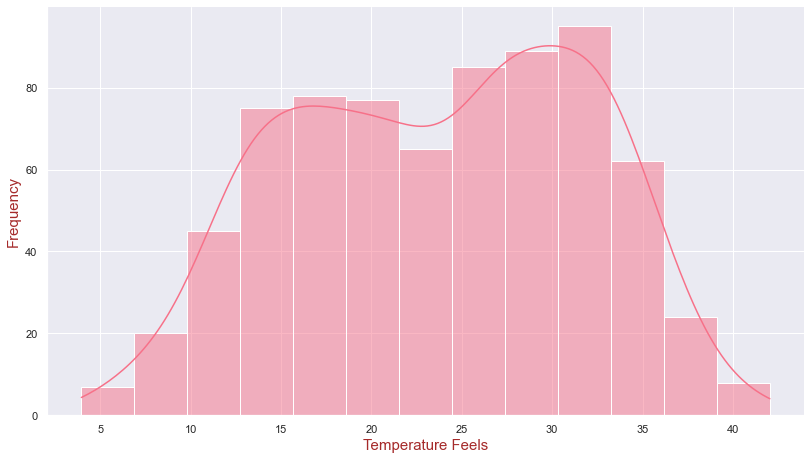

In [393]:
sns.displot(data=df,x="atemp",kde=True,height=6.5,aspect=1.75)
plt.xlabel('Temperature Feels',fontdict=fontdict)
plt.ylabel('Frequency',fontdict=fontdict)
plt.show()

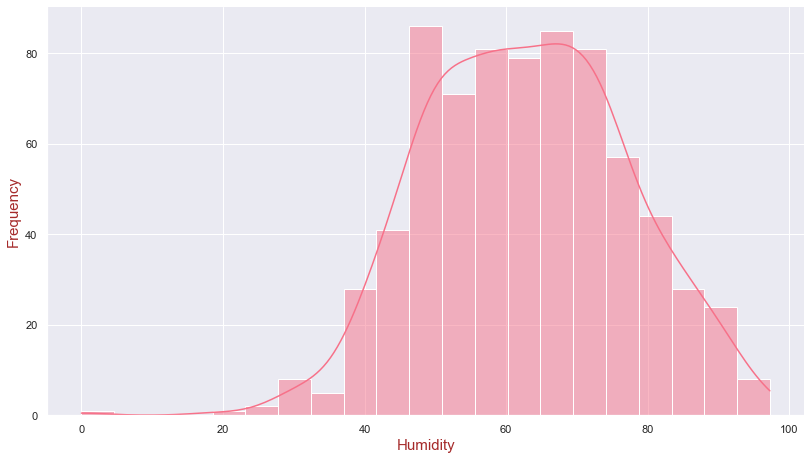

In [394]:
sns.displot(data=df,x="hum",kde=True,height=6.5,aspect=1.75)
plt.xlabel('Humidity',fontdict=fontdict)
plt.ylabel('Frequency',fontdict=fontdict)
plt.show()

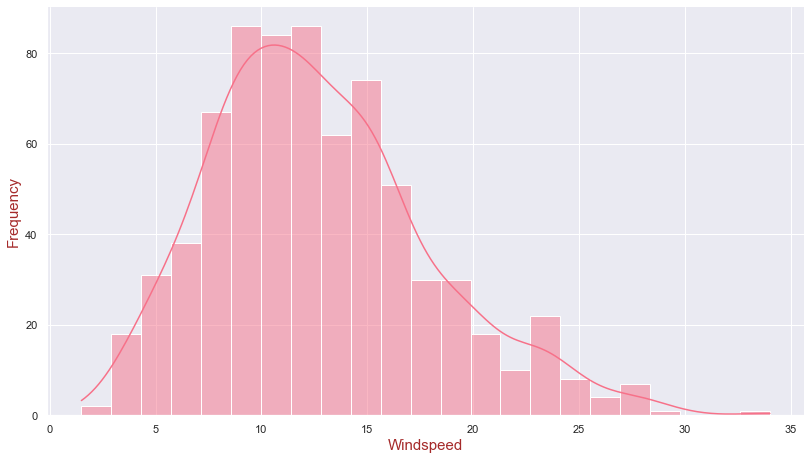

In [395]:
sns.displot(data=df,x="windspeed",kde=True,height=6.5,aspect=1.75)
plt.xlabel('Windspeed',fontdict=fontdict)
plt.ylabel('Frequency',fontdict=fontdict)
plt.show()

Since bikes are rented by casual or registered users, let's just analyse the ratio of registered users to total. This may or may not be useful going forward, but no harm in analying that

In [396]:
def calRegUserRatio(x):
    return x["registered"]/(x["casual"] + x["registered"])

# regUsersRatio is short for registeredUsersRatioOfTotalUsers
df["regUsersRatio"] = df.apply(calRegUserRatio, axis=1)
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,regUsersRatio
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985,0.663959
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801,0.836454
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,0.911045
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,0.930858
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,0.948750


In [397]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   instant        730 non-null    int64  
 1   dteday         730 non-null    object 
 2   season         730 non-null    int64  
 3   yr             730 non-null    int64  
 4   mnth           730 non-null    int64  
 5   holiday        730 non-null    int64  
 6   weekday        730 non-null    int64  
 7   workingday     730 non-null    int64  
 8   weathersit     730 non-null    int64  
 9   temp           730 non-null    float64
 10  atemp          730 non-null    float64
 11  hum            730 non-null    float64
 12  windspeed      730 non-null    float64
 13  casual         730 non-null    int64  
 14  registered     730 non-null    int64  
 15  cnt            730 non-null    int64  
 16  regUsersRatio  730 non-null    float64
dtypes: float64(5), int64(11), object(1)
memory usage: 97.1

So we don't have null values present here, so no need to handle those

let's derive day from 'dteday'

In [398]:
df["day"] = pd.DatetimeIndex(df["dteday"]).day
df.head(15)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,regUsersRatio,day
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985,0.663959,1
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801,0.836454,1
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,0.911045,1
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,0.930858,1
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,0.948750,1
5,6,06-01-2018,1,0,1,0,4,1,1,8.378268,11.66045,51.8261,6.000868,88,1518,1606,0.945205,1
6,7,07-01-2018,1,0,1,0,5,1,2,8.057402,10.44195,49.8696,11.304642,148,1362,1510,0.901987,1
7,8,08-01-2018,1,0,1,0,6,0,2,6.765000,8.11270,53.5833,17.875868,68,891,959,0.929093,1
8,9,09-01-2018,1,0,1,0,0,0,1,5.671653,5.80875,43.4167,24.250650,54,768,822,0.934307,1
9,10,10-01-2018,1,0,1,0,1,1,1,6.184153,7.54440,48.2917,14.958889,41,1280,1321,0.968963,1


`Notice the derived 'day' column. Till 12th row it is 1, and then suddenly it jumps to 13. So we can see that dteday is not currectly set up. It is of the form dd-mm-yyyy. We will break it manually using split function.`

In [399]:
df["day"] = df["dteday"].apply(lambda x: int(str(x).split('-')[0]))
df.head(15)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,regUsersRatio,day
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985,0.663959,1
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801,0.836454,2
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,0.911045,3
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,0.930858,4
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,0.948750,5
5,6,06-01-2018,1,0,1,0,4,1,1,8.378268,11.66045,51.8261,6.000868,88,1518,1606,0.945205,6
6,7,07-01-2018,1,0,1,0,5,1,2,8.057402,10.44195,49.8696,11.304642,148,1362,1510,0.901987,7
7,8,08-01-2018,1,0,1,0,6,0,2,6.765000,8.11270,53.5833,17.875868,68,891,959,0.929093,8
8,9,09-01-2018,1,0,1,0,0,0,1,5.671653,5.80875,43.4167,24.250650,54,768,822,0.934307,9
9,10,10-01-2018,1,0,1,0,1,1,1,6.184153,7.54440,48.2917,14.958889,41,1280,1321,0.968963,10


Now we can see that 'day' column is showing correct value

Let's create a date column that would be correctly set up

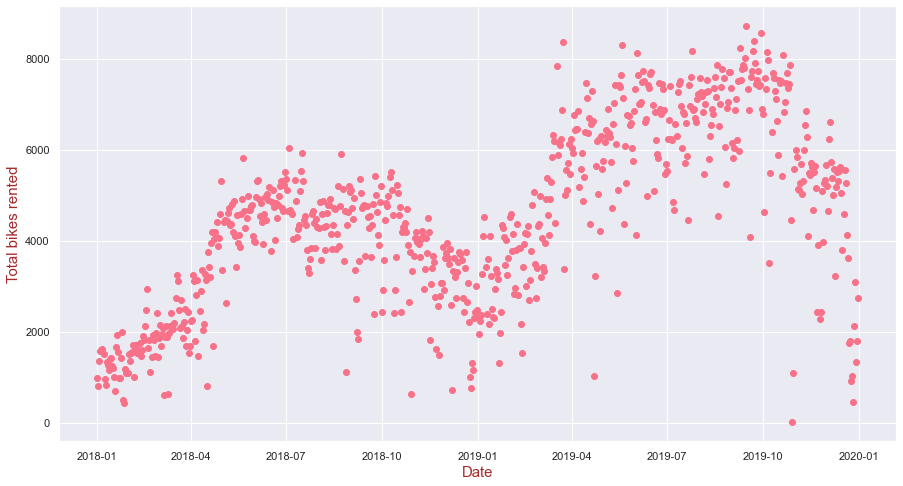

In [400]:
from datetime import date

# Creating the right date column with values in correct format
# since 'dteday' column was error prone
def addDate(df):
    yr = 2018
    if df["yr"] == 1:
        yr = 2019
    return date(yr, int(df["mnth"]), int(df["day"]))

df["date"] = df.apply(addDate, axis=1)
plt.scatter(df["date"],df["cnt"])
plt.xlabel('Date', fontdict=fontdict)
plt.ylabel('Total bikes rented', fontdict=fontdict) 
plt.show()

Now, we will draw the pattern of bikes rented by casual vs registered users with respect to time

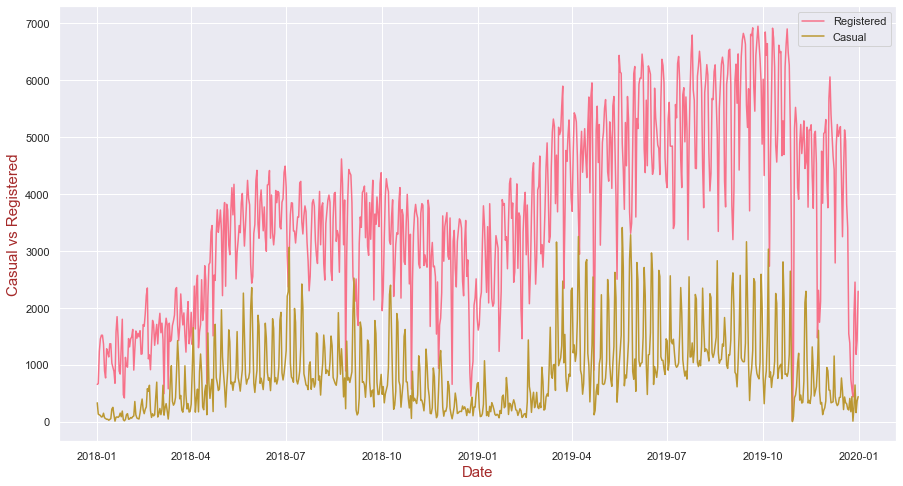

In [401]:
sns.lineplot(data=df,y = "registered", x="date")
sns.lineplot(data=df,y = "casual", x="date")
plt.xlabel('Date', fontdict=fontdict)
plt.ylabel('Casual vs Registered', fontdict=fontdict) 
plt.legend(['Registered','Casual'])
plt.show()

As we noticed above, registered users rented way more bikes consistenly than the casual users, but their pattern across time seems pretty similar

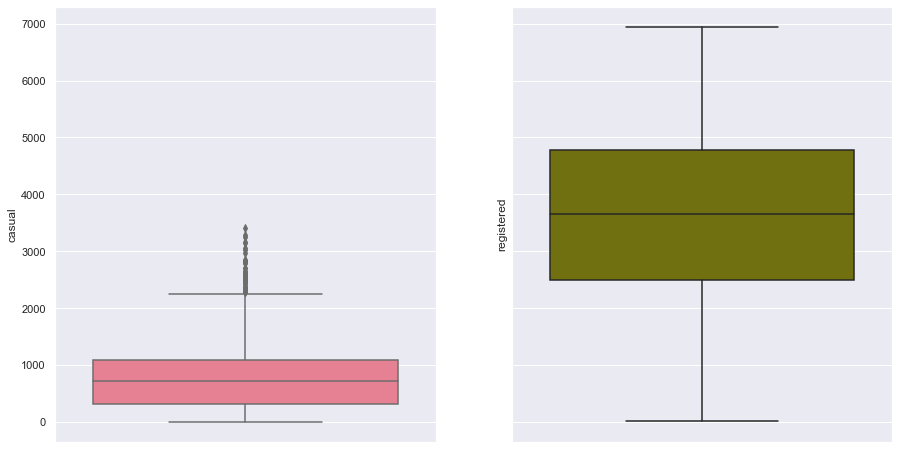

In [402]:
f, ax = plt.subplots(ncols = 2, sharey= True)
sns.boxplot(data=df, y = "casual", ax=ax[0])
sns.boxplot(data= df, y = "registered",ax=ax[1],color='olive')
plt.show()

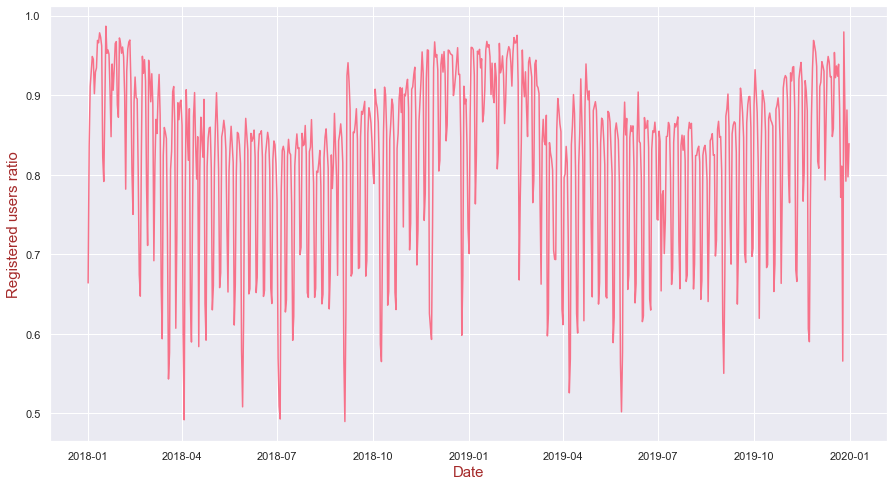

In [403]:
sns.lineplot(data=df,y = "regUsersRatio", x="date")
plt.xlabel('Date', fontdict=fontdict)
plt.ylabel('Registered users ratio', fontdict=fontdict) 
plt.show()

Interesting pattern here. The ratio of registered users vs total users starts good, goes down during middle of the year and then picks up again during the year end. And the pattern repeated for the year 2019 as well. May be or may not be useful information but good to know. 

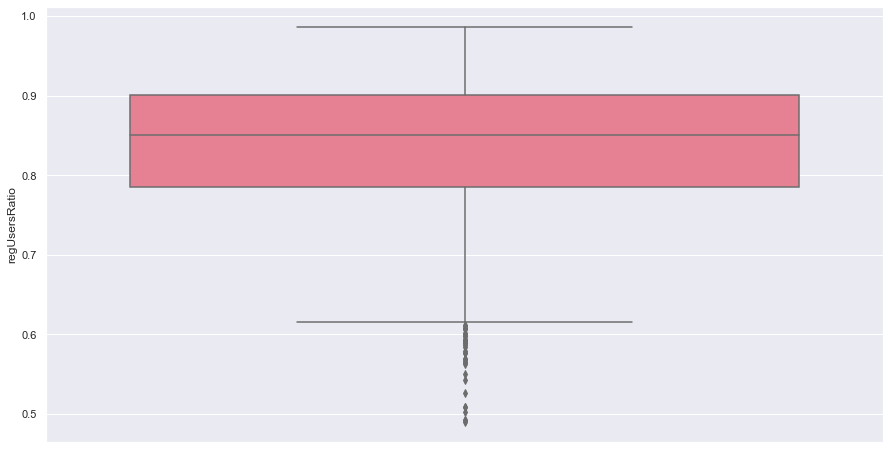

In [404]:
sns.boxplot(data=df, y = "regUsersRatio")
plt.show()

regUsersRatio was derived just for observing if there any patterns. We are not going to use it for deriving model since our target variable itself is made up of registered users + casual users renting the bikes

In [405]:
df.drop(["regUsersRatio"],axis=1,inplace=True)

#####  Let's conver the values in the categorical column to string values since the numeric values in them falsely implies that there is some order in the values, when there is no such order

In [406]:
def getSeasons(x):
    if x ==1:
        return "spring"
    elif x==2:
        return "summer"
    elif x==3:
        return "fall"
    else:
        return "winter"
    
df["season"] = df["season"].apply(getSeasons)
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day,date
0,1,01-01-2018,spring,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985,1,2018-01-01
1,2,02-01-2018,spring,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801,2,2018-01-02
2,3,03-01-2018,spring,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,3,2018-01-03
3,4,04-01-2018,spring,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,4,2018-01-04
4,5,05-01-2018,spring,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,5,2018-01-05


In [407]:
df["season"].unique()

array(['spring', 'summer', 'fall', 'winter'], dtype=object)

In [408]:
df["weathersit"].unique()

array([2, 1, 3], dtype=int64)

In [409]:
df["weekday"].unique()

array([6, 0, 1, 2, 3, 4, 5], dtype=int64)

In [410]:
df["weekday_1"] = df["date"].apply(lambda x: x.weekday())
df[["weekday_1","weekday"]].head(7)

,weekday_1,weekday
0,0,6
1,1,0
2,2,1
3,3,2
4,4,3
5,5,4
6,6,5


Here we can see that derived weekday_1 column has different values from the weekday given in the dataset. According to the documentation Monday is 0 and Sunday is 6.

In [411]:
def getDayOfTheWeek(x):
    if x==0:
        return "Monday"
    elif x==1:
        return "Tuesday"
    elif x==2:
        return "Wednesday"
    elif x==3:
        return "Thursday"
    elif x==4:
        return "Friday"
    elif x==5:
        return "Saturday"
    else:
        return "Sunday"
    
df["weekday"] = df["weekday_1"].apply(getDayOfTheWeek)
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day,date,weekday_1
0,1,01-01-2018,spring,0,1,0,Monday,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985,1,2018-01-01,0
1,2,02-01-2018,spring,0,1,0,Tuesday,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801,2,2018-01-02,1
2,3,03-01-2018,spring,0,1,0,Wednesday,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,3,2018-01-03,2
3,4,04-01-2018,spring,0,1,0,Thursday,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,4,2018-01-04,3
4,5,05-01-2018,spring,0,1,0,Friday,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,5,2018-01-05,4


In [412]:
df.drop(["weekday_1"],axis=1,inplace=True)

In [413]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day,date
0,1,01-01-2018,spring,0,1,0,Monday,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985,1,2018-01-01
1,2,02-01-2018,spring,0,1,0,Tuesday,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801,2,2018-01-02
2,3,03-01-2018,spring,0,1,0,Wednesday,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,3,2018-01-03
3,4,04-01-2018,spring,0,1,0,Thursday,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,4,2018-01-04
4,5,05-01-2018,spring,0,1,0,Friday,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,5,2018-01-05


In [414]:
def getWeatherSituation(x):
    if x==1:
        return "Clear" # Clear, Few clouds, Partly cloudy, Partly cloudy
    elif x==2:
        return "Cloudy" # Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    elif x==3:
        return "Light Rain" # Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    else:
        return "Heavy Rain" # Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
    
df["weathersit"] = df["weathersit"].apply(getWeatherSituation)
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day,date
0,1,01-01-2018,spring,0,1,0,Monday,0,Cloudy,14.110847,18.18125,80.5833,10.749882,331,654,985,1,2018-01-01
1,2,02-01-2018,spring,0,1,0,Tuesday,0,Cloudy,14.902598,17.68695,69.6087,16.652113,131,670,801,2,2018-01-02
2,3,03-01-2018,spring,0,1,0,Wednesday,1,Clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349,3,2018-01-03
3,4,04-01-2018,spring,0,1,0,Thursday,1,Clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562,4,2018-01-04
4,5,05-01-2018,spring,0,1,0,Friday,1,Clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600,5,2018-01-05


let's do some segmented univariate analysis and check the pattern of categorical variables with respect to the shared bikes count, the dependent variable

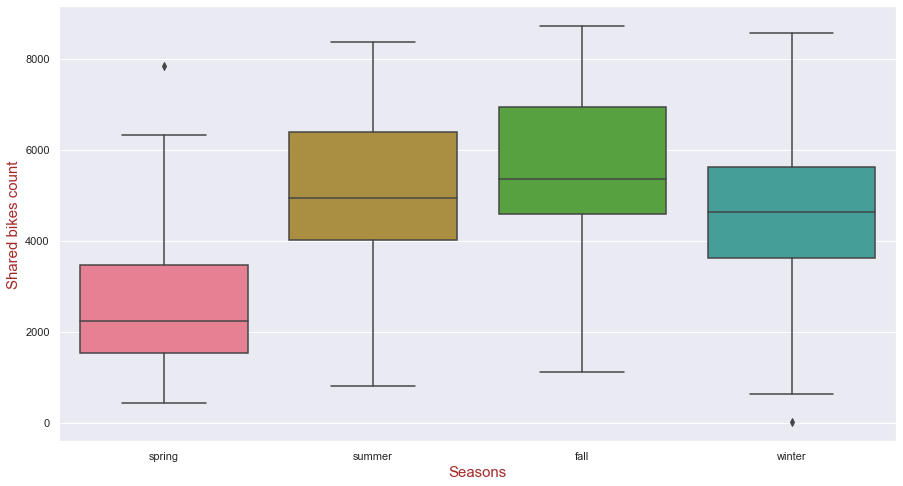

In [415]:
sns.set(rc={'figure.figsize' : (15,8)})
sns.set_theme(palette=sns.color_palette("husl"))
sns.boxplot(data=df , x = "season", y = "cnt")
plt.xlabel('Seasons',fontdict=fontdict)
plt.ylabel('Shared bikes count',fontdict=fontdict)
plt.show()

'fall' is the clear winner here, while 'spring' generally has the lowest shared bikes count

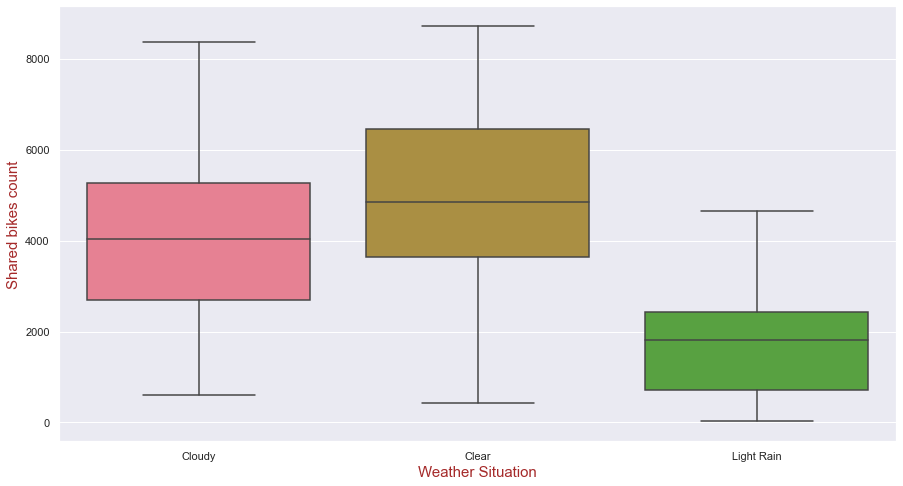

In [416]:
sns.set(rc={'figure.figsize' : (15,8)})
sns.set_theme(palette=sns.color_palette("husl"))
sns.boxplot(data=df , x = "weathersit", y = "cnt")
plt.xlabel('Weather Situation',fontdict=fontdict)
plt.ylabel('Shared bikes count',fontdict=fontdict)
plt.show()

The pattern across the weather situation is prettu intuitibve in itself. Users would like to ride a bike in clear weather and they would like to avoid it during rainfall, and the data shows the same insight.

In [417]:
df["mnth"].value_counts()

1     62
3     62
5     62
7     62
8     62
10    62
12    62
4     60
6     60
9     60
11    60
2     56
Name: mnth, dtype: int64

In [418]:
def getMonthName(x):
    if x==1:
        return "January"
    elif x==2:
        return "February"
    elif x==3:
        return "March"
    elif x==4:
        return "April"
    elif x==5:
        return "May"
    elif x==6:
        return "June"
    elif x==7:
        return "July"
    elif x==8:
        return "August"
    elif x==9:
        return "September"
    elif x==10:
        return "October"
    elif x==11:
        return "November"
    else:
        return "December"

df["mnth"] = df["mnth"].apply(getMonthName)

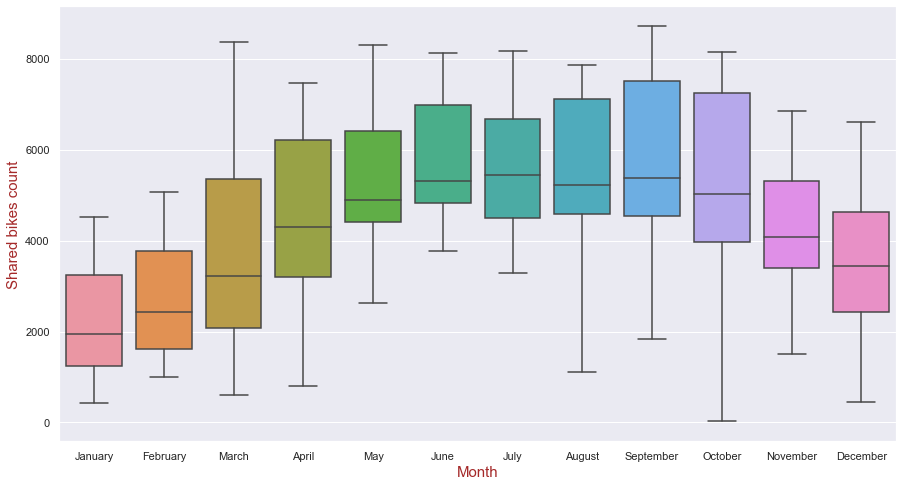

In [419]:
sns.set(rc={'figure.figsize' : (15,8)})
sns.boxplot(data=df , x = "mnth", y = "cnt")
plt.xlabel('Month',fontdict=fontdict)
plt.ylabel('Shared bikes count',fontdict=fontdict)
plt.show()

As seen above, the bikes are rented more during the mid months of the year as compared to year start and year end.

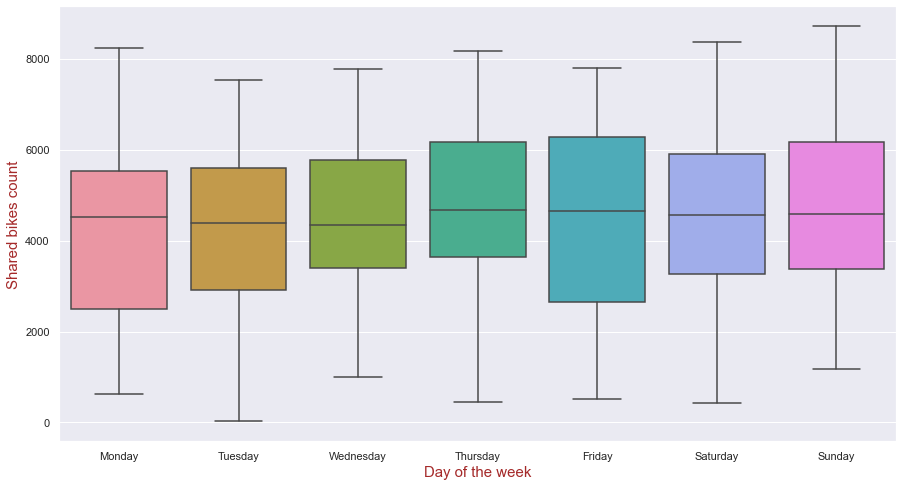

In [420]:
sns.set(rc={'figure.figsize' : (15,8)})
sns.set_theme(palette=sns.color_palette("husl"))
sns.boxplot(data=df , x = "weekday", y = "cnt")
plt.xlabel('Day of the week',fontdict=fontdict)
plt.ylabel('Shared bikes count',fontdict=fontdict)
plt.show()

So, not much of a pattern to notice for shared bikes count with respect to days of the week

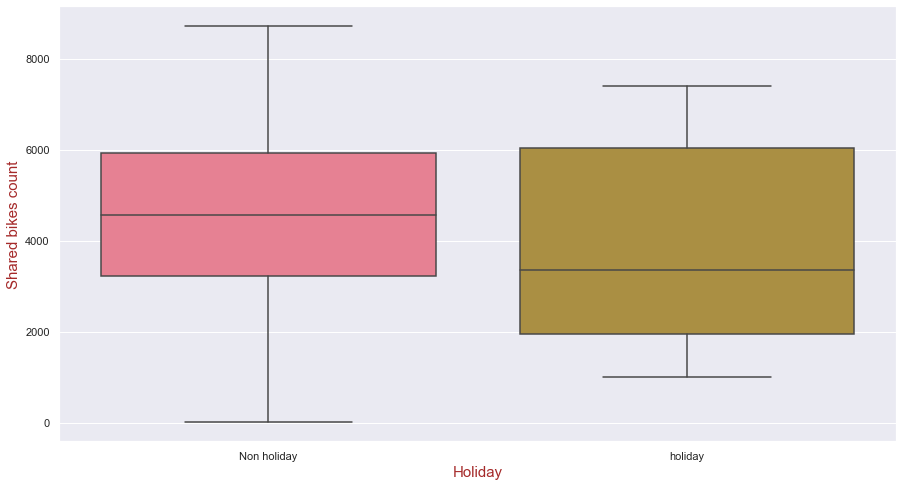

In [421]:
sns.set(rc={'figure.figsize' : (15,8)})
sns.set_theme(palette=sns.color_palette("husl"))
sns.boxplot(data=df , x = "holiday", y = "cnt")
plt.xlabel('Holiday',fontdict=fontdict)
plt.ylabel('Shared bikes count',fontdict=fontdict)
locs, texts = plt.xticks()
plt.xticks(locs, list(map(lambda x: 'Non holiday' if x ==0 else 'holiday', locs)))
plt.show()

Users generally like to rent the bikes during non holiday days. There could be multiple reasons, users generally rent the bike while going to work, or they generally want to spend time with family or go out of the station during holidays, hence the drop during holidays

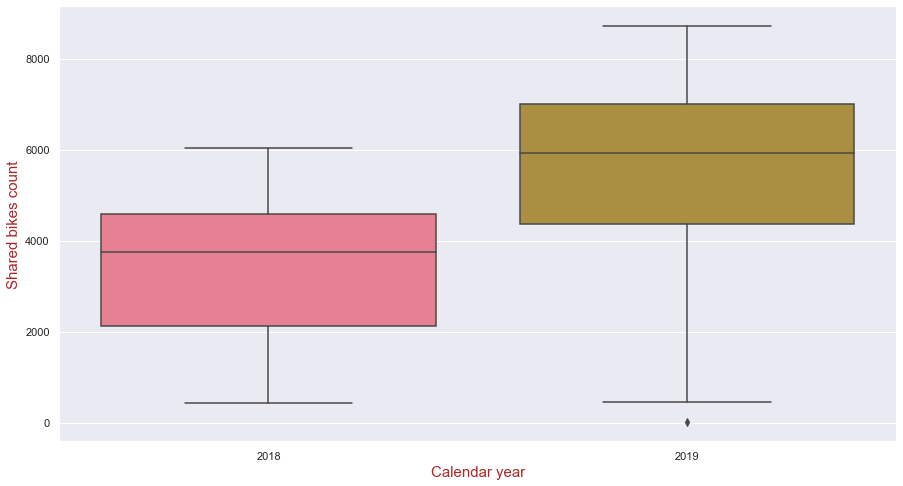

In [422]:
sns.set(rc={'figure.figsize' : (15,8)})
sns.set_theme(palette=sns.color_palette("husl"))
sns.boxplot(data=df , x = "yr", y = "cnt")
plt.xlabel('Calendar year',fontdict=fontdict)
plt.ylabel('Shared bikes count',fontdict=fontdict)
locs, texts = plt.xticks()
plt.xticks(locs, list(map(lambda x: '2018' if x ==0 else '2019', locs)))
plt.show()

This is very clear pattern, the shared bikes count boomed in year 2019 as compared to 2018. May be the word of mouth, or better advertising, or just increased awareness of the company among consumers played a role in that boom.

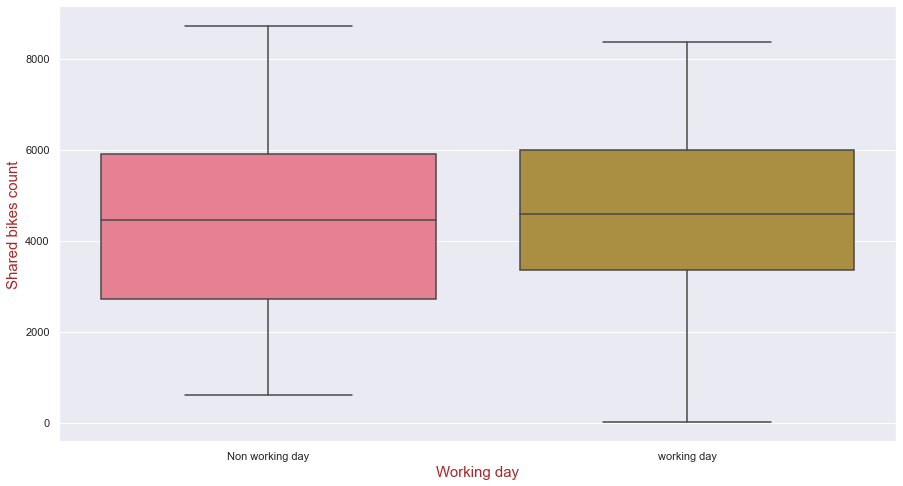

In [423]:
sns.set(rc={'figure.figsize' : (15,8)})
sns.set_theme(palette=sns.color_palette("husl"))
sns.boxplot(data=df , x = "workingday", y = "cnt")
plt.xlabel('Working day',fontdict=fontdict)
plt.ylabel('Shared bikes count',fontdict=fontdict)
locs, texts = plt.xticks()
plt.xticks(locs, list(map(lambda x: 'Non working day' if x ==0 else 'working day', locs)))
plt.show()

Not much of a difference here, but non working day's 25th percentile is lower than that of working day. Probably the thought we put down for holiday vs non holiday - that people tend to rent the bike while going to work - is substantiated by above plot.

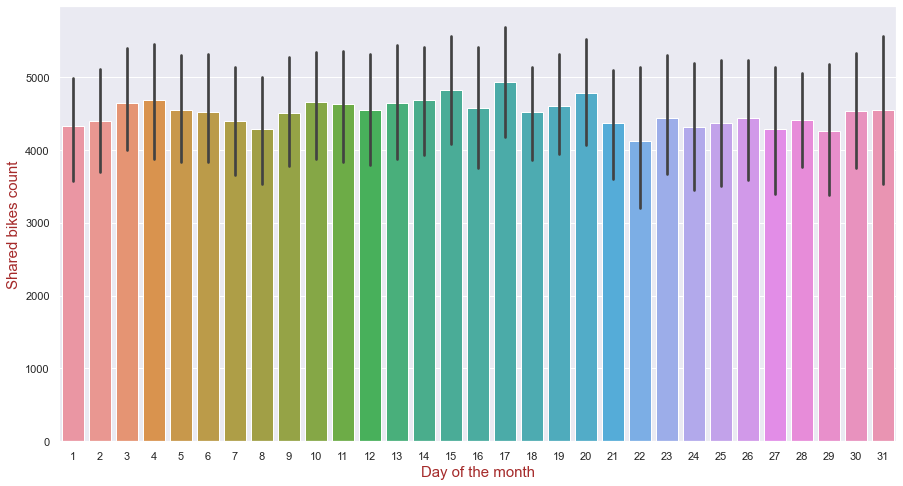

In [424]:
sns.set(rc={'figure.figsize' : (15,8)})
sns.set_theme(palette=sns.color_palette("husl"))
sns.barplot(data=df , x = "day", y = "cnt")
plt.xlabel('Day of the month',fontdict=fontdict)
plt.ylabel('Shared bikes count',fontdict=fontdict)
plt.show()

Not much of a pattern to notice for rented bikes count with respect to day of the month

#### Now let's start the main process of preparing data for model buildiing

First we will create dummies columns for categorical variables. We will delete one of the column out of the column created for each level of a categorical variable, since all values of a categorical column with m levels can be represented by m-1 columns.

In [425]:
categVars = ["season","weekday","weathersit","mnth"]

In [426]:
for cv in categVars:
    dummydf = pd.get_dummies(df[cv],drop_first=True) # drop_first = True will remove the redundant column
    df= pd.concat([df, dummydf],axis=1)
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,...,December,February,January,July,June,March,May,November,October,September
0,1,01-01-2018,spring,0,January,0,Monday,0,Cloudy,14.110847,...,0,0,1,0,0,0,0,0,0,0
1,2,02-01-2018,spring,0,January,0,Tuesday,0,Cloudy,14.902598,...,0,0,1,0,0,0,0,0,0,0
2,3,03-01-2018,spring,0,January,0,Wednesday,1,Clear,8.050924,...,0,0,1,0,0,0,0,0,0,0
3,4,04-01-2018,spring,0,January,0,Thursday,1,Clear,8.200000,...,0,0,1,0,0,0,0,0,0,0
4,5,05-01-2018,spring,0,January,0,Friday,1,Clear,9.305237,...,0,0,1,0,0,0,0,0,0,0


Now, we will drop the original categorical variables, since they won't be needed anymore

In [427]:
df.drop(categVars,axis=1,inplace=True)

In [428]:
df.shape

(730, 36)

Next, we will remove the unneeded columns. 

'instant' just shows the row number, won't be useful for creating models.

'casual' and 'registered' are just the break up of 'cnt' variable - if we build a model to predict 'cnt' - we are basically predicting 'casual' + 'registered'.

'dteday' is not needed since we have derived metrics from that - date and year (month was already given)

'date' was nothing but a proxy of dteday that we created to plot some graphs.

So we will remove these columns.

In [429]:
df.drop(["instant","dteday","casual","registered","date"],axis=1,inplace=True)
df.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'cnt', 'day', 'spring', 'summer', 'winter', 'Monday', 'Saturday',
       'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'Cloudy', 'Light Rain',
       'August', 'December', 'February', 'January', 'July', 'June', 'March',
       'May', 'November', 'October', 'September'],
      dtype='object')

Splitting the data into `train` and `test`. We will keep 70% of the total data as the train data.

In [430]:
df_train, df_test = train_test_split(df, train_size= 0.7, random_state=100)
print(df_train.shape)
print(df_test.shape)

(510, 31)
(220, 31)


In [431]:
df.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,day,spring,...,December,February,January,July,June,March,May,November,October,September
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,1,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,2,1,...,0,0,1,0,0,0,0,0,0,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,3,1,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,4,1,...,0,0,1,0,0,0,0,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,5,1,...,0,0,1,0,0,0,0,0,0,0


In [432]:
numVars = ["temp","atemp","hum","windspeed"]

Next step in model building is the scaling of numerical variables. We will use `Normalization` to scale the numerical variables, so that the values remain between 0 and 1.

In [433]:
scaler = MinMaxScaler()

In [434]:
df_train[numVars] = scaler.fit_transform(df_train[numVars])
df_train[numVars].head()

,temp,atemp,hum,windspeed
576,0.815169,0.766351,0.725633,0.264686
426,0.442393,0.438975,0.640189,0.255342
728,0.245101,0.200348,0.498067,0.663106
482,0.395666,0.391735,0.504508,0.188475
111,0.345824,0.318819,0.751824,0.380981


In [435]:
df_train[numVars].describe()

,temp,atemp,hum,windspeed
count,510.000000,510.000000,510.000000,510.000000
mean,0.537440,0.513156,0.650480,0.320883
std,0.225858,0.212410,0.145846,0.169803
min,0.000000,0.000000,0.000000,0.000000
25%,0.339853,0.332086,0.538643,0.199179
50%,0.542596,0.529718,0.653714,0.296763
75%,0.735215,0.688457,0.754830,0.414447
max,1.000000,1.000000,1.000000,1.000000


Now we will plot the heatmap to check the correlation numbers among numerical variables along with dependent variable

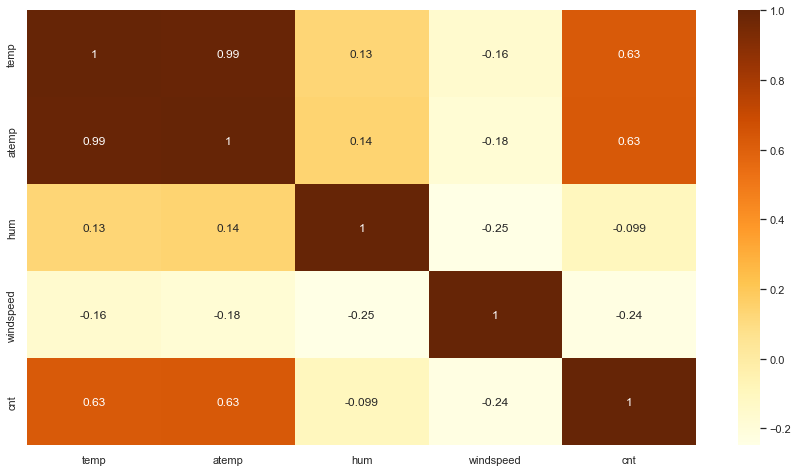

In [436]:
sns.set(rc = {'figure.figsize' : (15,8)})
correlationCheckVars = numVars + ['cnt']
sns.heatmap(df[correlationCheckVars].corr(),cmap="YlOrBr", annot=True)
plt.show()

temperature and real feel temperature are highly correlated. We can drop any of them right now, but we are going to keep them for time being, since while selecting features via REF or while checking VIF we are going to drop one of them anyways

Next we will break the training data to separate dependent and predictor variables

In [437]:
df.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'cnt', 'day', 'spring', 'summer', 'winter', 'Monday', 'Saturday',
       'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'Cloudy', 'Light Rain',
       'August', 'December', 'February', 'January', 'July', 'June', 'March',
       'May', 'November', 'October', 'September'],
      dtype='object')

In [438]:
y_train = df_train.pop('cnt')
X_train = df_train.copy(deep=True)

In [439]:
# Running RFE with the output number of the variable equal to 12
lm = LinearRegression()
lm.fit(X_train,y_train) # model training

rfe = RFE(lm,n_features_to_select = 12)
rfe = rfe.fit(X_train, y_train) # selecting top 12 features based on xtrain and ytrain

In [440]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 18),
 ('temp', True, 1),
 ('atemp', False, 6),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('day', False, 19),
 ('spring', True, 1),
 ('summer', True, 1),
 ('winter', True, 1),
 ('Monday', False, 8),
 ('Saturday', False, 16),
 ('Sunday', False, 13),
 ('Thursday', False, 15),
 ('Tuesday', False, 7),
 ('Wednesday', False, 11),
 ('Cloudy', True, 1),
 ('Light Rain', True, 1),
 ('August', False, 10),
 ('December', False, 4),
 ('February', False, 5),
 ('January', False, 2),
 ('July', True, 1),
 ('June', False, 12),
 ('March', False, 17),
 ('May', False, 9),
 ('November', False, 3),
 ('October', False, 14),
 ('September', True, 1)]

Let's check which columns are declared unimportant by RFE

In [441]:
X_train.columns[~rfe.support_]

Index(['workingday', 'atemp', 'day', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday', 'August', 'December', 'February',
       'January', 'June', 'March', 'May', 'November', 'October'],
      dtype='object')

Let's check the important predictors identified by RFE

In [442]:
X_train.columns[rfe.support_]

Index(['yr', 'holiday', 'temp', 'hum', 'windspeed', 'spring', 'summer',
       'winter', 'Cloudy', 'Light Rain', 'July', 'September'],
      dtype='object')

Next, we will select the important columns predicted by RFE for further analysis

In [443]:
col = X_train.columns[rfe.support_]
X_train_rfe = X_train[col]

Adding constant to predictor variables.

So equation could become y = `b0` + b1x1 + b2x2 ... bnxn where `b0` is the constant added

In [444]:
X_train_rfe = sm.add_constant(X_train_rfe)

In [445]:
X_train_rfe.head(2)

,const,yr,holiday,temp,hum,windspeed,spring,summer,winter,Cloudy,Light Rain,July,September
576,1.0,1,0,0.815169,0.725633,0.264686,0,0,0,0,0,1,0
426,1.0,1,0,0.442393,0.640189,0.255342,1,0,0,1,0,0,0


In [446]:
# function for training the model
def trainModel(y_train,X_train_rfe):
    lm = sm.OLS(y_train,X_train_rfe).fit() 
    print(lm.summary())
    return lm

In [447]:
trainModel(y_train,X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     220.6
Date:                Sun, 06 Nov 2022   Prob (F-statistic):          2.95e-190
Time:                        18:35:23   Log-Likelihood:                -4116.5
No. Observations:                 510   AIC:                             8259.
Df Residuals:                     497   BIC:                             8314.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2497.0845    299.726      8.331      0.0

`Observations after training the model`

-  All the `P values` of beta coefficients are insignificant (basically all beta values are important)

In [448]:
# function for checking multicollinearity
def calculateVIF(x):
    vif = pd.DataFrame()
    vif['Features'] = x.columns
    vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    print(vif)

In [449]:
calculateVIF(X_train_rfe)

      Features    VIF
0        const  74.37
6       spring   5.02
3         temp   3.61
8       winter   3.48
7       summer   2.62
4          hum   1.89
9       Cloudy   1.56
11        July   1.48
12   September   1.30
10  Light Rain   1.24
5    windspeed   1.19
1           yr   1.03
2      holiday   1.02


`spring` has a little higher VIF, so we will drop it

In [450]:
X_train_rfe = X_train_rfe.drop(["spring"], axis = 1)

In [451]:
lm = trainModel(y_train,X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     237.0
Date:                Sun, 06 Nov 2022   Prob (F-statistic):          6.89e-190
Time:                        18:35:23   Log-Likelihood:                -4120.2
No. Observations:                 510   AIC:                             8264.
Df Residuals:                     498   BIC:                             8315.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1988.3324    234.539      8.478      0.0

`Observations after dropping spring and training the model again`

-  R square and Adjusted R square almost remain unaffected (very small change)


In [452]:
calculateVIF(X_train_rfe)

      Features    VIF
0        const  44.97
4          hum   1.87
3         temp   1.60
8       Cloudy   1.55
10        July   1.43
6       summer   1.33
7       winter   1.29
9   Light Rain   1.24
11   September   1.19
5    windspeed   1.18
1           yr   1.03
2      holiday   1.02


`constant` has a high VIF but since we have created the constant manually, we know that it is not a combination of other independent variables, so we can ignore its multicollinearity

There is no issue of multicollinearity in the remaining columns

`So we have our model ready since we don't need to drop any more variables`

#### Now let's validate the assumptions of linear regression

-  error terms should be normally distributed
-  Homoscedasticity should be present
-  Error terms should not form any pattern over time
-  predictors and dependent variable should form a linear relationship

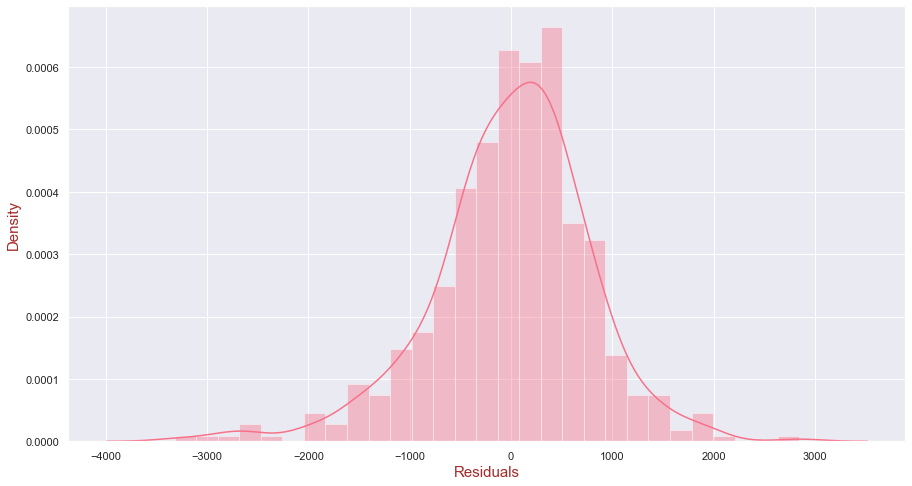

In [453]:
sns.set_theme(palette=sns.color_palette("husl"))
y_train_pred = lm.predict(X_train_rfe)
res = y_train - y_train_pred
sns.distplot(res)
plt.xlabel('Residuals',fontdict=fontdict)
plt.ylabel('Density',fontdict=fontdict)
plt.show()

So we can see here that error terms are normally distributed with mean around 0

We can also plot Q-Q plot to confirm if error terms are indeed normally distributed

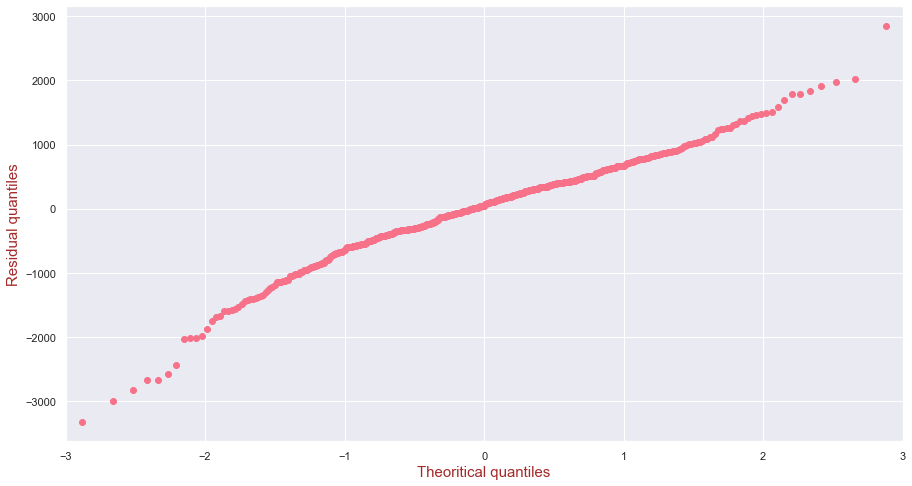

In [454]:
sm.qqplot(res)
plt.xlabel('Theoritical quantiles',fontdict=fontdict)
plt.ylabel('Residual quantiles',fontdict=fontdict)
plt.show()

Next, we can plot error terms against the predicted y values and check for `Homoscedasticity`

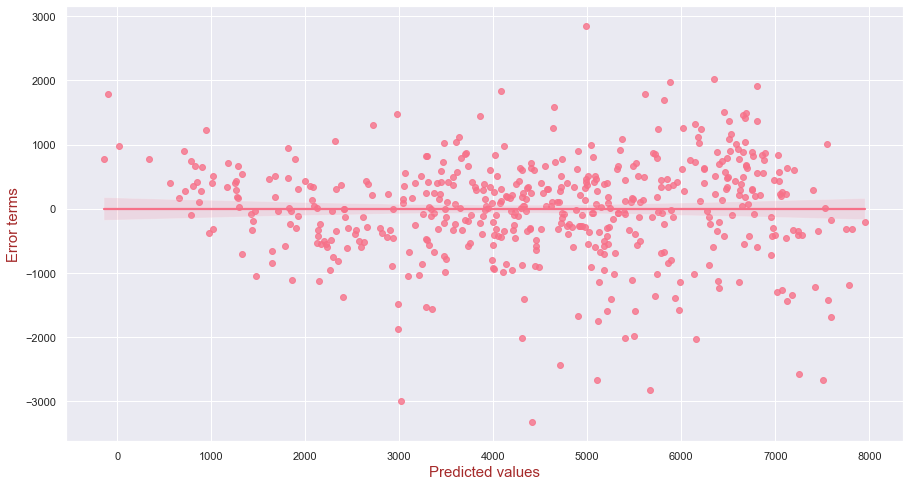

In [455]:
sns.regplot(x=y_train_pred, y = res)
plt.xlabel('Predicted values',fontdict=fontdict)
plt.ylabel('Error terms',fontdict=fontdict)
plt.show()

Next we will plot error terms against time (date in this case) to confirm there should not be any patterns

In [456]:
X_train_with_date = X_train.copy(deep=True) # we will add date in upcoming steps

In [457]:
X_train_with_date.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'day', 'spring', 'summer', 'winter', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday', 'Cloudy', 'Light Rain', 'August',
       'December', 'February', 'January', 'July', 'June', 'March', 'May',
       'November', 'October', 'September'],
      dtype='object')

In [458]:
mnth_cols = ['August','December', 'February', 'January', 'July', 'June', 'March', 'May','November', 'October', 'September']

mnth_dict = {'January' : 1, 'February':2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August':8, 'September': 9, 'October': 10, 'November': 11, 'December': 12 }

# we will iterate through the month columns of X_train_with_date
# if any of the column has value 1 for a given row, we will fill the month number (from mnth_dict) in newly created mnth column
def getMonth(x):
    for month in mnth_cols:
        if x[month] == 1:
            return mnth_dict[month]
    return 4

X_train_with_date["mnth"] = X_train_with_date.apply(getMonth,axis=1)

In [459]:
X_train_with_date["date"] = X_train_with_date.apply(addDate, axis=1)

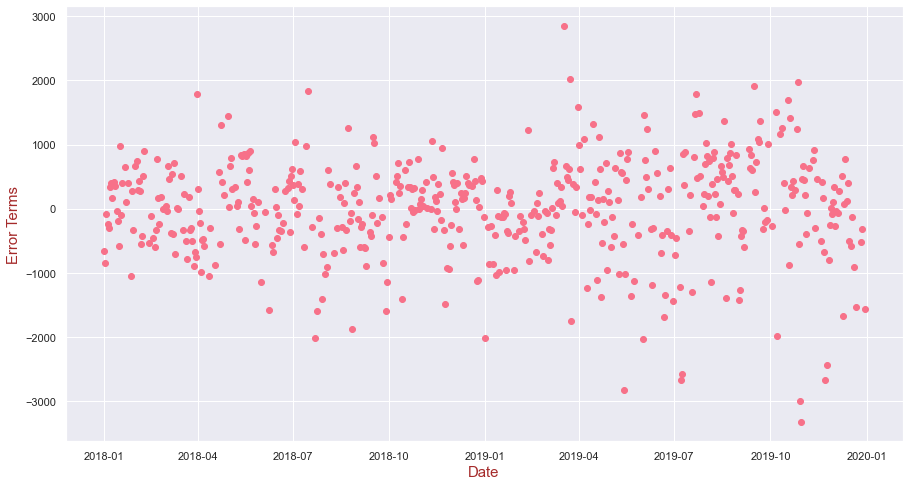

In [460]:
plt.scatter(X_train_with_date["date"],res)
plt.xlabel('Date',fontdict=fontdict)
plt.ylabel('Error Terms',fontdict=fontdict)
plt.show()

There is no pattern whatsoever among error terms with respect to time

#### Next we will test our model on test data

First, we will scale the numerical columns in test data to the same scale as that of corresponding columns in train data

In [461]:
df_test[numVars] = scaler.transform(df_test[numVars])
df_test[numVars].head()

,temp,atemp,hum,windspeed
184,0.831783,0.769660,0.657364,0.084219
535,0.901354,0.842587,0.610133,0.153728
299,0.511964,0.496145,0.837699,0.334206
221,0.881625,0.795343,0.437098,0.339570
152,0.817246,0.741471,0.314298,0.537414


In [462]:
df_test[numVars].describe()

,temp,atemp,hum,windspeed
count,220.000000,220.000000,220.000000,220.000000
mean,0.558718,0.532847,0.638221,0.313293
std,0.233187,0.217401,0.148694,0.159584
min,0.046591,0.025950,0.261915,-0.042808
25%,0.355429,0.344870,0.529197,0.198843
50%,0.558172,0.544652,0.625590,0.300126
75%,0.755981,0.713308,0.743798,0.402718
max,0.984424,0.980934,1.002146,0.807474


Next, separate dependent and independent variables

In [463]:
y_test = df_test.pop('cnt')

In [464]:
X_train_rfe_wo_const = X_train_rfe.drop(['const'],axis=1) # remove constant

Select columns in test data that were present in the final model, except constant

In [465]:
X_test = df_test[X_train_rfe_wo_const.columns]

Now we will add constant

In [466]:
X_test = sm.add_constant(X_test)

Now, we are ready to predict y values from test data

In [467]:
y_test_pred = lm.predict(X_test)

In [468]:
r2_score(y_true = y_test, y_pred =  y_test_pred)

0.8050021066128354

`This is a pretty good R2 score and it is quite close to the score we got in the training set`

#### So this is a pretty good model with a r2 score of 0.805 on test data.
#### Model equation:
####  cnt = 1988.33 + 1981.3yr - 859.72*holiday + 5195.64*temp - 1500.5*hum - 1646.97*windspeed + 708.65*summer + 1170.77*winter -436.27*Cloudy -2015.06*Light Rain -415.6*July + 835.94September 

Finally let's try to plot the regression plot between y_test and predicted values from test data

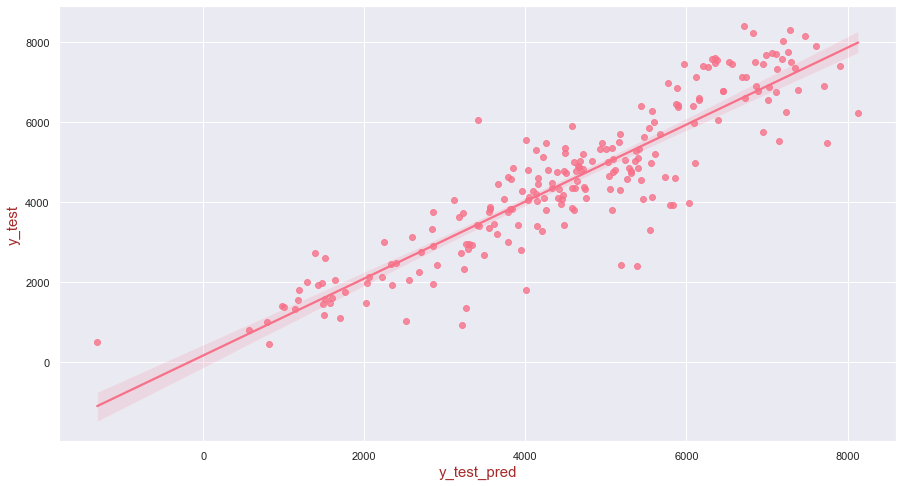

In [469]:
sns.regplot(y_test_pred,y_test)
plt.xlabel('y_test_pred', fontdict=fontdict)
plt.ylabel('y_test', fontdict=fontdict) 
plt.show()

`We can see that our model gave good and consistent result for both train and test data with a R square value of 0.84 and .805 for train and test data respectively`

#### Final notes

Model equation: cnt = 1988.33 + 1981.38yr - 859.72holiday + 5195.64temp - 1500.5hum - 1646.97windspeed + 708.65summer + 1170.77winter -436.27Cloudy -2015.06Light Rain -415.6July + 835.94September

Adjusted R2 value on train data = 0.836

R2 score on test data = 0.805



Going by this model, the three top features are

•	Temperature (count increases by 5195.64 units for every unit increase in temperature if other predictors are kept constant)

•	Light Rain (count decreases by 2015.06 units for every unit increase in humidity if other predictors are kept constant)

•	2019 year (count increases by 1981.38 units for every unit when year changed to 2019 if other predictors are kept constant)
